In [134]:
import pandas as pd
import seaborn as sns
from sqlalchemy import create_engine
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import math
from src.helper import *

# CZ Apartments for Sale

In [94]:
db_connection_str = "postgresql://localhost:5432/postgres"
db_connection = create_engine(db_connection_str)

query_props = "SELECT * FROM properties WHERE price_total IS NOT NULL;"
df = pd.read_sql(query_props, db_connection)

query_feats = "SELECT * FROM property_features;"
df_features = pd.read_sql(query_feats, db_connection)

print(f"Loaded {df.shape[0]} properties.")

Loaded 12534 properties.


In [95]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12534 entries, 0 to 12533
Data columns (total 36 columns):
 #   Column                    Non-Null Count  Dtype         
---  ------                    --------------  -----         
 0   id                        12534 non-null  int64         
 1   web_link                  12534 non-null  object        
 2   title                     12534 non-null  object        
 3   description               12534 non-null  object        
 4   category_sub              12534 non-null  object        
 5   price_total               12534 non-null  int64         
 6   currency                  12439 non-null  object        
 7   street                    12534 non-null  object        
 8   locality_region_id        12534 non-null  int64         
 9   district_id               12534 non-null  int64         
 10  municipality_id           12534 non-null  int64         
 11  latitude                  12534 non-null  float64       
 12  longitude         

data profiling with library

In [96]:
from ydata_profiling import ProfileReport
profile = ProfileReport(df, title="Real Estate Data Profiling")
profile.to_file("report.html")

Export report to file: 100%|██████████| 1/1 [00:00<00:00, 86.91it/s]


- data without duplicates
- id has unique values (primary key)
- web_link has unique values used to reference the actual public listing
- created_at has unique values represents the timestamp of data acquisition


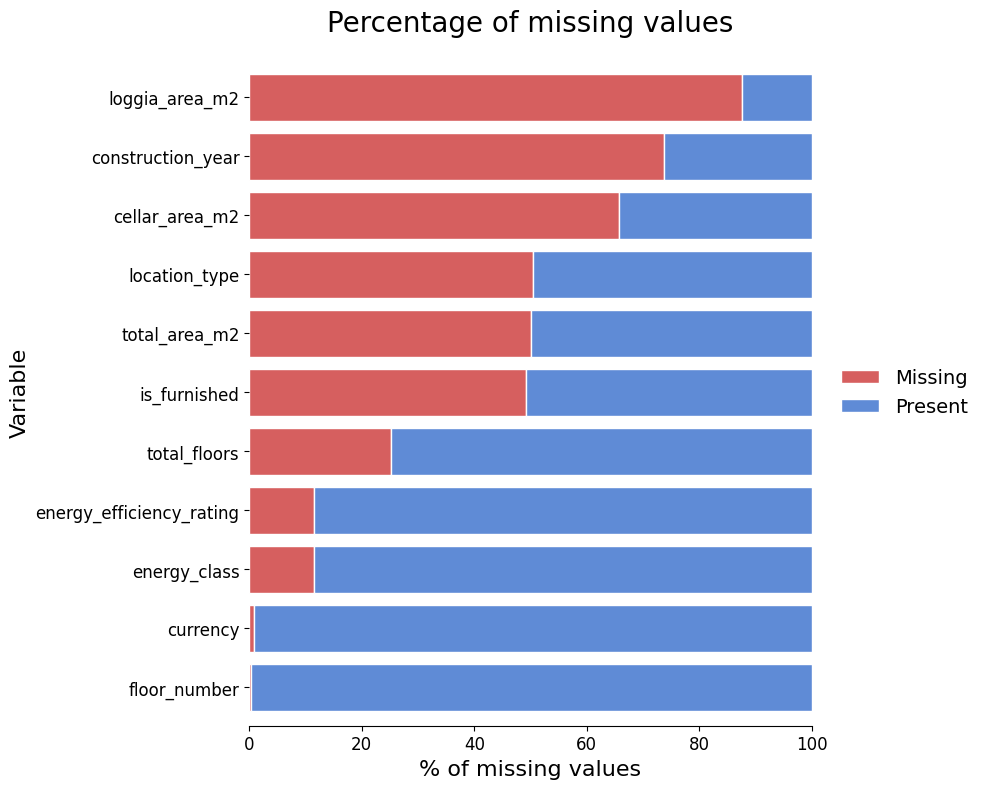

In [97]:
missing_series = df.isnull().mean() * 100

missing_data = missing_series[missing_series > 0]

missing_data = missing_data.sort_values(ascending=True)

plot_df = pd.DataFrame({
    'Missing': missing_data,
    'Present': 100 - missing_data
})

fig, ax = plt.subplots(figsize=(10, 8))

plot_df.plot(
    kind='barh', 
    stacked=True, 
    ax=ax, 
    color=['#d65f5f', '#5f8bd6'], 
    width=0.8,
    edgecolor='white' 
)

ax.set_title('Percentage of missing values', fontsize=20, pad=20)
ax.set_xlabel('% of missing values', fontsize=16)
ax.set_ylabel('Variable', fontsize=16)

ax.legend(labels=['Missing', 'Present'], bbox_to_anchor=(1.02, 0.5), loc='center left', frameon=False, fontsize=14)

ax.set_xlim(0, 100)

ax.tick_params(axis='both', which='major', labelsize=12)

sns.despine(left=True, bottom=False)

plt.tight_layout()
plt.show()

* **Missing data handling:**

  * Missing values in the *loggia* field indicate that the property does not include a loggia.
  * The same assumption applies to the *cellar area* field; missing values imply the absence of a cellar.
  * Missing values in *usable area* are inferred from the *total area*, i.e., the usable area is assumed to be equal to the total area when not explicitly provided.
  * Missing values in the *currency* field occur for discounted properties; however, the *total price* remains correctly recorded in CZK.


In [98]:
df['currency'] = df['currency'].fillna('CZK')
df['loggia_area_m2'] = df['loggia_area_m2'].fillna(0.0)
df['cellar_area_m2'] = df['cellar_area_m2'].fillna(0.0)
df['total_area_m2'] = df['total_area_m2'].fillna(df['usable_area_m2'])

In [99]:
df.describe()

,id,price_total,locality_region_id,district_id,municipality_id,latitude,longitude,usable_area_m2,total_area_m2,loggia_area_m2,cellar_area_m2,floor_number,total_floors,construction_year,created_at
count,1.253400e+04,1.253400e+04,12534.000000,12534.000000,12534.000000,12534.000000,12534.000000,12534.000000,12534.000000,12534.000000,12534.000000,12489.000000,9367.000000,3292.000000,12534
mean,2.157173e+09,7.878773e+06,8.650471,1623.687570,3179.071246,49.908768,15.091027,72.676001,82.828307,0.785543,1.681427,3.127232,5.355076,2000.298299,2026-01-01 03:28:02.976587776
min,5.865720e+05,5.783140e+05,1.000000,1.000000,1.000000,48.599843,12.171178,11.000000,1.000000,0.000000,0.000000,1.000000,1.000000,1.000000,2025-12-22 04:57:39.828139
25%,1.076235e+09,4.200000e+06,5.000000,28.000000,1818.000000,49.601956,14.363583,52.000000,53.000000,0.000000,0.000000,2.000000,3.000000,1980.000000,2025-12-22 05:02:40.368481024
50%,2.185309e+09,6.527795e+06,10.000000,62.000000,3468.000000,50.051765,14.506038,67.000000,68.000000,0.000000,0.000000,3.000000,5.000000,2019.000000,2026-01-05 02:25:39.986575104
75%,3.216776e+09,9.551896e+06,11.000000,5004.000000,3919.000000,50.132530,16.163374,84.000000,88.000000,0.000000,2.000000,4.000000,7.000000,2025.000000,2026-01-05 02:30:31.716833280
max,4.294919e+09,1.050000e+08,14.000000,5010.000000,103609.000000,51.003688,18.766009,675.000000,14439.000000,103.000000,106.000000,21.000000,51.000000,2028.000000,2026-01-05 02:35:12.101182
std,1.243827e+09,5.994590e+06,3.796588,2314.092632,1783.946502,0.486352,1.413279,35.000458,257.229768,2.681139,4.231596,2.224558,2.955991,58.610232,NaN


In [100]:
for col in df.select_dtypes(include=['int64']).columns:
    num_unique = df[col].nunique()
    print(f"Column '{col}' has {num_unique} unique values.")

Column 'id' has 12534 unique values.
Column 'price_total' has 4350 unique values.
Column 'locality_region_id' has 14 unique values.
Column 'district_id' has 87 unique values.
Column 'municipality_id' has 1058 unique values.
Column 'usable_area_m2' has 261 unique values.


In [101]:
df["district_id"].value_counts()

district_id
5005    871
72      845
5004    690
5009    562
5010    511
       ... 
15       32
6        32
47       31
59       27
8        26
Name: count, Length: 87, dtype: int64

In [102]:
for col in df.select_dtypes(include=['object']).columns:
    num_unique = df[col].nunique()
    print(f"Column '{col}' has {num_unique} unique values.")

Column 'web_link' has 12534 unique values.
Column 'title' has 1887 unique values.
Column 'description' has 12152 unique values.
Column 'category_sub' has 12 unique values.
Column 'currency' has 2 unique values.
Column 'street' has 6065 unique values.
Column 'construction_type' has 8 unique values.
Column 'building_condition' has 9 unique values.
Column 'ownership_type' has 3 unique values.
Column 'location_type' has 6 unique values.
Column 'energy_class' has 7 unique values.
Column 'energy_efficiency_rating' has 28 unique values.
Column 'is_furnished' has 3 unique values.
Column 'meta_description' has 12296 unique values.
Column 'updated' has 207 unique values.


In [103]:
energy_classes=df['energy_class'].value_counts()
missing_energy = df['energy_class'].isnull().sum()
energy_classes['Missing'] = missing_energy
energy_classes = energy_classes.sort_index()
energy_classes.sort_index()

energy_class
A           879
B          3427
C          1634
D           938
E           354
F           171
G          3685
Missing    1446
Name: count, dtype: int64

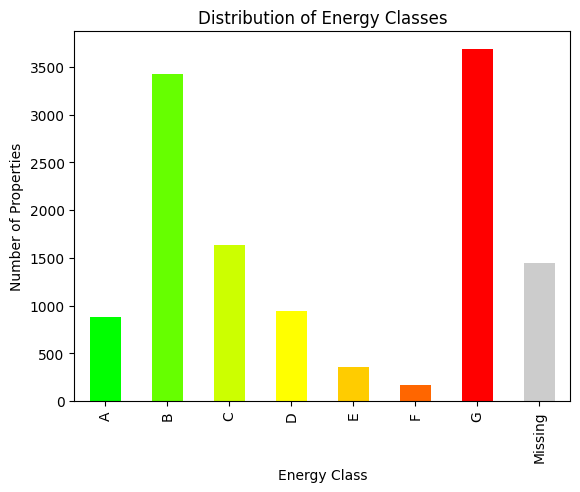

In [104]:
energy_gradient = {
    'A': '#00FF00',  # Bright Green
    'B': '#66FF00',  # Light Green
    'C': '#CCFF00',  # Yellow-Green
    'D': '#FFFF00',  # Yellow
    'E': '#FFCC00',  # Orange-Yellow
    'F': '#FF6600',  # Orange
    'G': '#FF0000',  # Red
    'Missing': '#CCCCCC'  # Gray for unknown
}
energy_classes.sort_index().plot(kind='bar', color=[energy_gradient.get(cls, '#000000') for cls in energy_classes.sort_index().index])
plt.title('Distribution of Energy Classes')
plt.xlabel('Energy Class')
plt.ylabel('Number of Properties')
plt.show()

- Energy class “G” could be used as a temporary placeholder when an official energy assessment has not yet been completed. Therefore, class G does not reliably represent true energy efficiency.

In [105]:
top_streets = df['street'].value_counts().head(40)
top_streets


street
Brno, okres Brno-město                                             157
Zborovská, Český Brod                                               68
Jerlínová, Brno - Žebětín                                           68
Nádražní, Praha 5 - Smíchov                                         64
Komárkova, Praha 4 - Chodov                                         57
Vosátkova, Praha - Kamýk                                            54
Wassermannova, Praha 5 - Hlubočepy                                  46
Hábova, Praha 5 - Stodůlky                                          43
Lipno nad Vltavou, okres Český Krumlov                              41
Harrachov, okres Jablonec nad Nisou                                 41
Silurská, Praha 5 - Hlubočepy                                       40
Šlapanice, okres Brno-venkov                                        39
Mánesova, Lipník nad Bečvou - Lipník nad Bečvou I-Město             38
Tábor - Měšice, okres Tábor                                         35

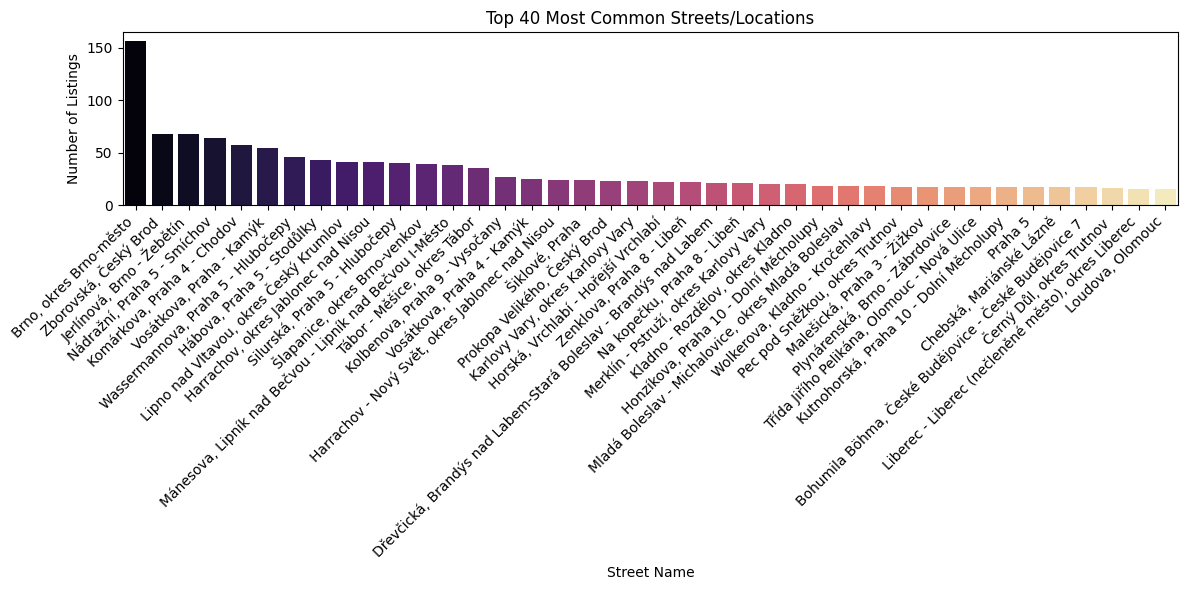

In [106]:
plt.figure(figsize=(12, 6))

sns.barplot(
    x=top_streets.index, 
    y=top_streets.values, 
    palette='magma' ,
    hue=top_streets.index
)

plt.title('Top 40 Most Common Streets/Locations')
plt.xlabel('Street Name')
plt.ylabel('Number of Listings')
plt.xticks(rotation=45, ha='right') 
plt.tight_layout() 
plt.show()

frequent locality can mean offers from Developer projects

In [107]:
df['currency'].value_counts()

currency
Kč     12439
CZK       95
Name: count, dtype: int64

- currency is in czk (we can leave it out)

In [108]:
layout_counts = df['category_sub'].value_counts()
layout_counts.sort_index(inplace=True)
layout_counts

category_sub
1+1          459
1+kk        1146
2+1         1388
2+kk        3078
3+1         1954
3+kk        2666
4+1          451
4+kk        1014
5+1           64
5+kk         182
6-a-vice      46
atypicky      86
Name: count, dtype: int64

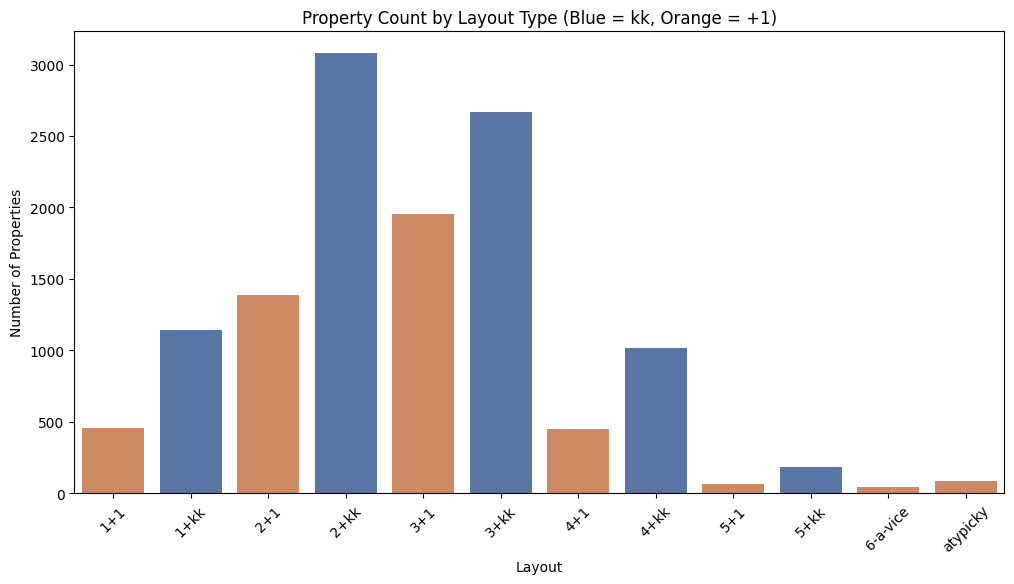

In [109]:
plt.figure(figsize=(12, 6))

colors = ['#4c72b0' if 'kk' in x else '#dd8452' for x in layout_counts.index]
sns.barplot(x=layout_counts.index, y=layout_counts.values, palette=colors,hue=layout_counts.index)
plt.title('Property Count by Layout Type (Blue = kk, Orange = +1)')
plt.xlabel('Layout')
plt.ylabel('Number of Properties')
plt.xticks(rotation=45)
plt.show()

In [110]:
# df['category_sub'] = df['category_sub'].astype('category').cat.codes

In [111]:
df["usable_area_m2"].describe()

count    12534.000000
mean        72.676001
std         35.000458
min         11.000000
25%         52.000000
50%         67.000000
75%         84.000000
max        675.000000
Name: usable_area_m2, dtype: float64

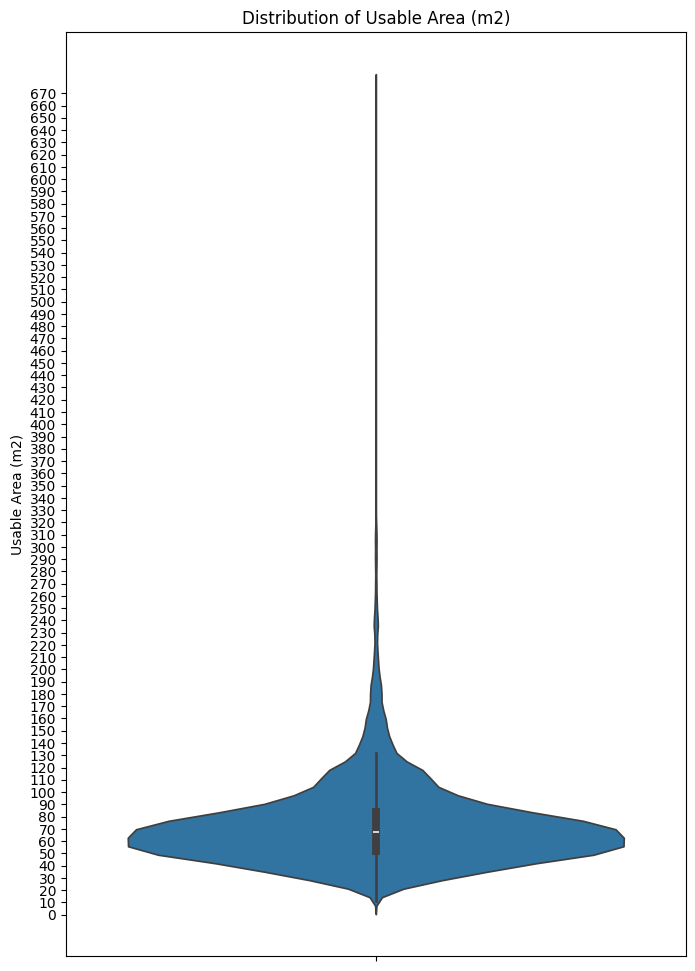

In [112]:
plt.figure(figsize=(8, 12))
sns.violinplot(y=df["usable_area_m2"])
plt.title('Distribution of Usable Area (m2)')
plt.ylabel('Usable Area (m2)')
plt.yticks(range(0, max(df["usable_area_m2"]), 10)) 

plt.show()

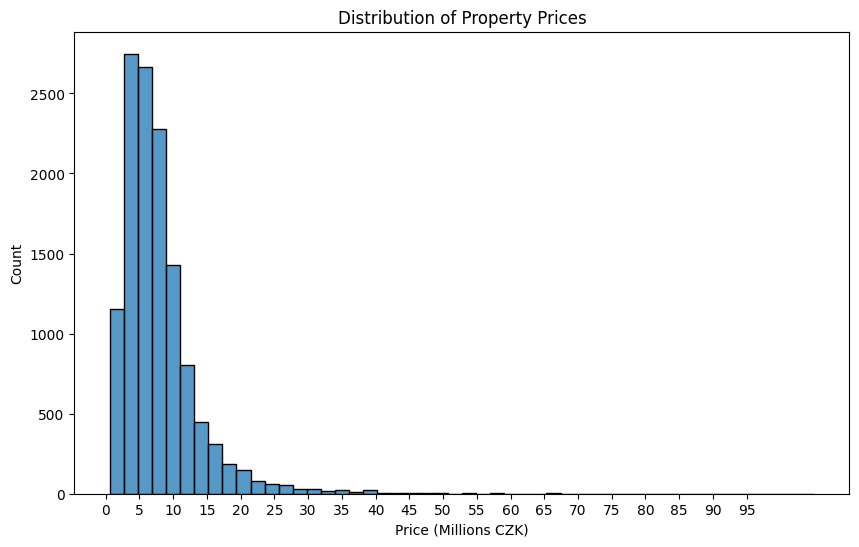

In [113]:
df['price_millions'] = df['price_total'] / 1_000_000

plt.figure(figsize=(10, 6))

sns.histplot(df['price_millions'], bins=50)

plt.title('Distribution of Property Prices')
plt.xlabel('Price (Millions CZK)')  
plt.ylabel('Count')

plt.xticks(range(0, 100, 5)) 

plt.show()



count    12534.000000
mean         7.878773
std          5.994590
min          0.578314
25%          4.200000
50%          6.527795
75%          9.551896
max        105.000000
Name: price_millions, dtype: float64


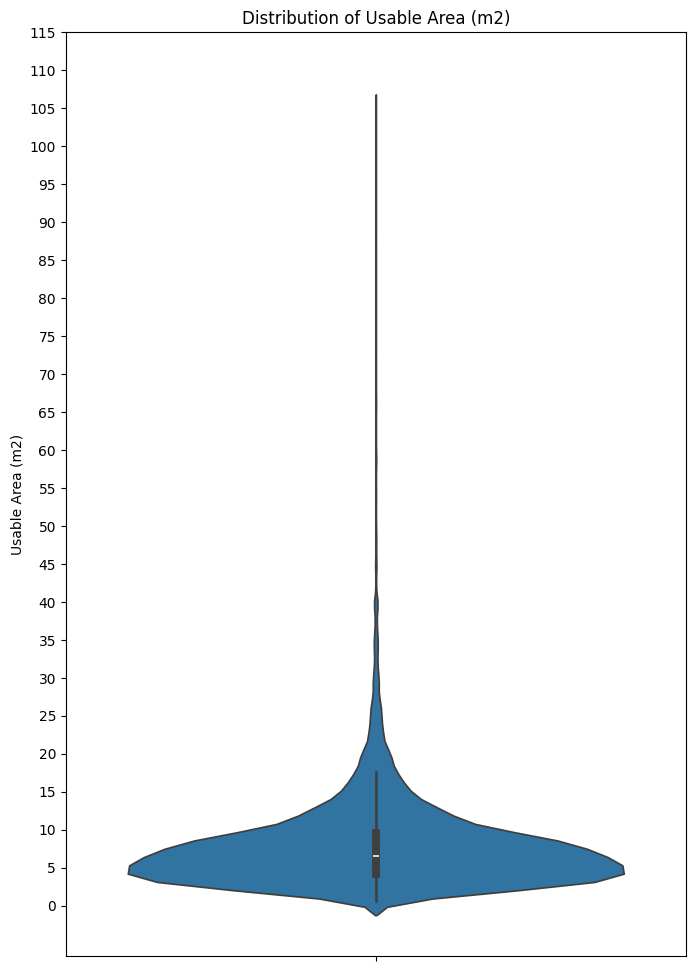

In [114]:
print(df["price_millions"].describe())
plt.figure(figsize=(8, 12))
sns.violinplot(y=df["price_millions"])
plt.title('Distribution of Usable Area (m2)')
plt.ylabel('Usable Area (m2)')
plt.yticks(range(0, 120, 5)) 

plt.show()

price analysis target price_total and price_per_m2

In [115]:
df["price_per_m2"] = df["price_total"] / df["usable_area_m2"]

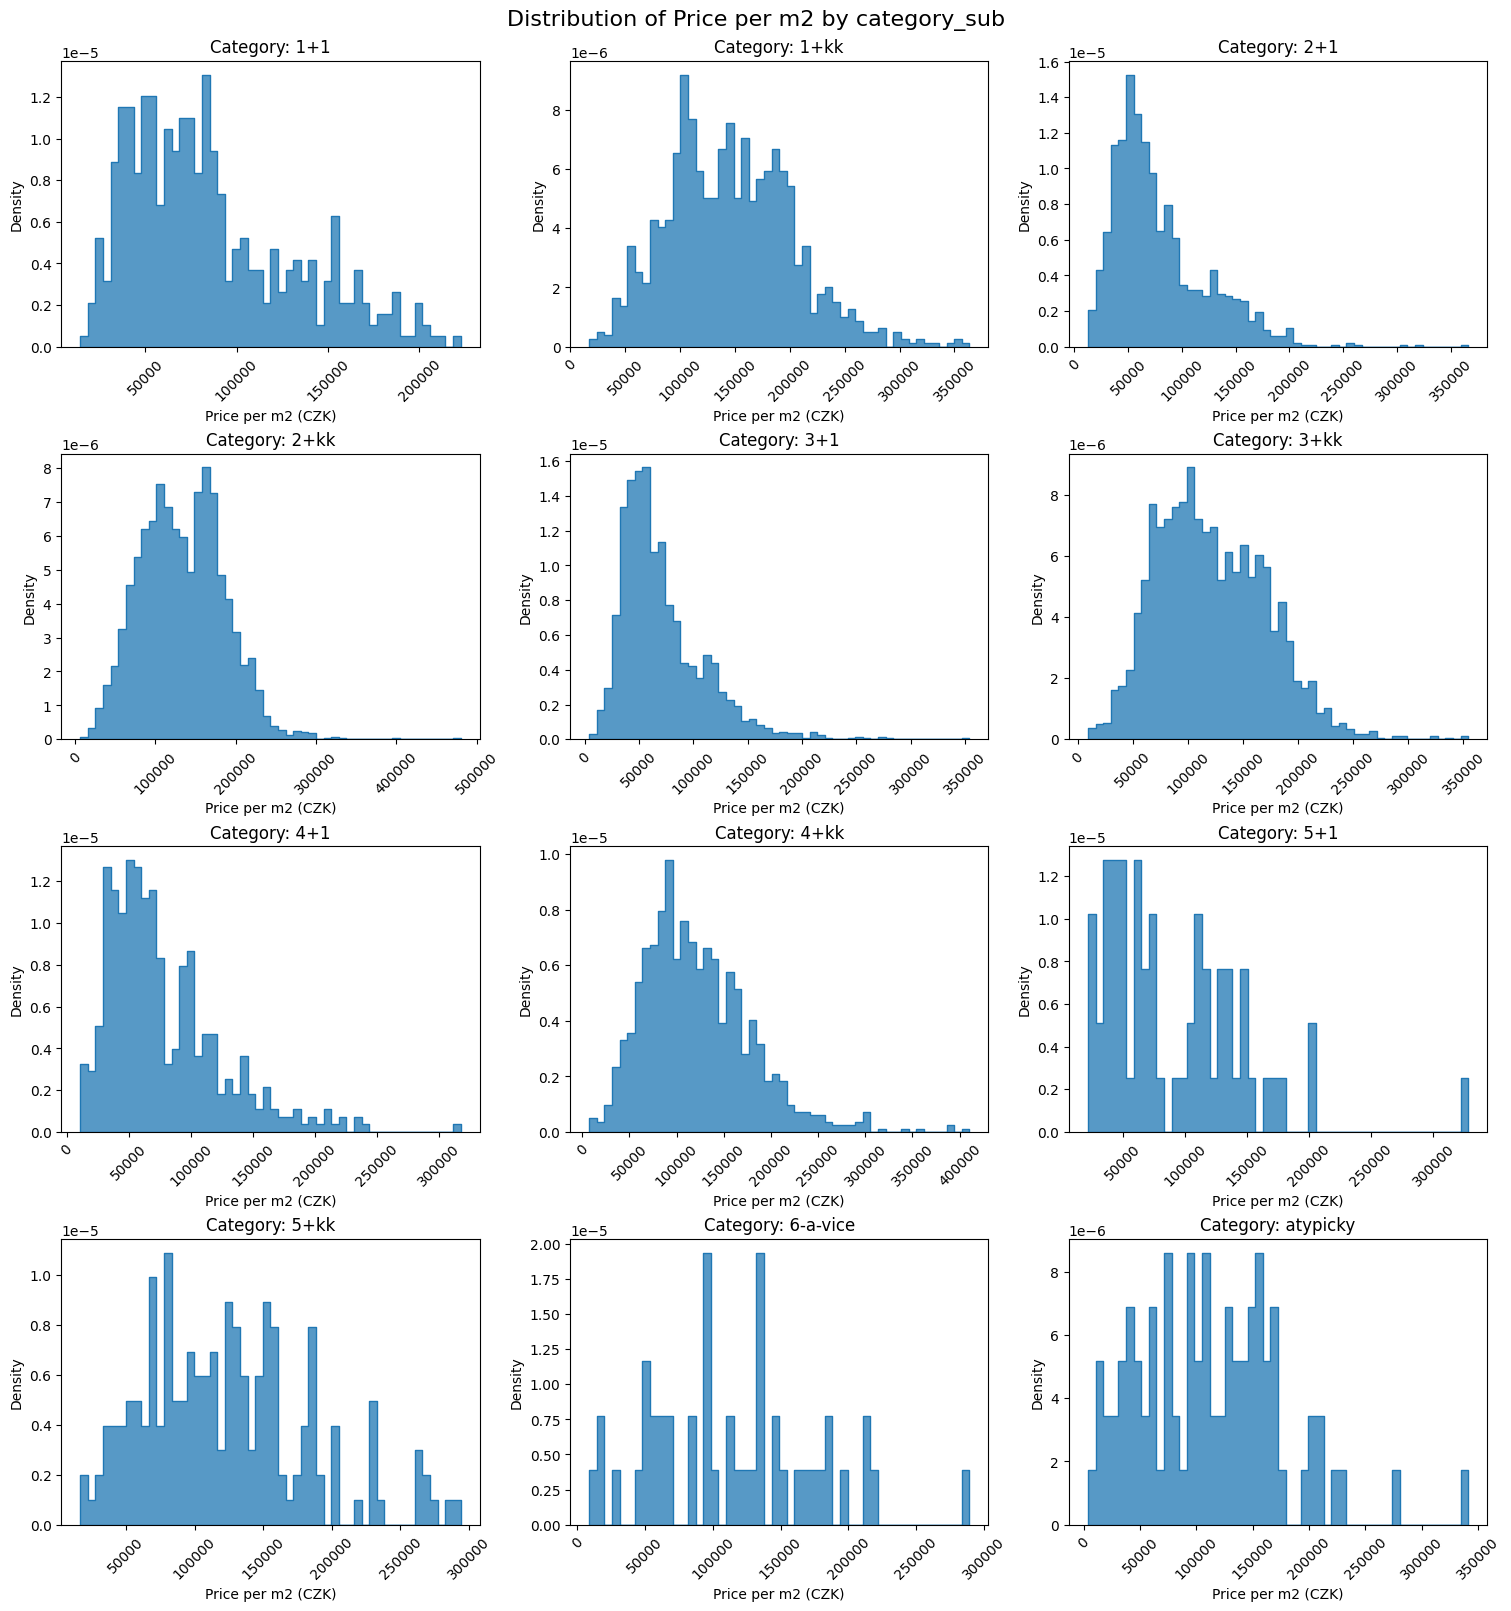

In [ ]:
def hist_price_based_on_category(column_name: str,map: dict = None):
    categories = sorted(df[column_name].unique())
    n_categories = len(categories)
    
    cols = 3
    rows = math.ceil(n_categories / cols)
    
    fig, axes = plt.subplots(rows, cols, figsize=(15, rows * 4), constrained_layout=True)
    axes = axes.flatten()  
    
    for i, category in enumerate(categories):
        subset = df[df[column_name] == category]
        
        sns.histplot(
            data=subset, 
            x='price_per_m2', 
            bins=50, 
            kde=False, 
            stat="density", 
            element="step", 
            ax=axes[i]
        )
        axes[i].tick_params(axis='x', rotation=45)
        if map:
            axes[i].set_title(f'Category: {map[category]}')
        else:
            axes[i].set_title(f'Category: {category}')
        axes[i].set_xlabel('Price per m2 (CZK)')
        axes[i].set_ylabel('Density')

    for j in range(i + 1, len(axes)):
        fig.delaxes(axes[j])
        
    plt.suptitle(f'Distribution of Price per m2 by {column_name}', fontsize=16)
    plt.show()


In [ ]:
hist_price_based_on_category('category_sub')

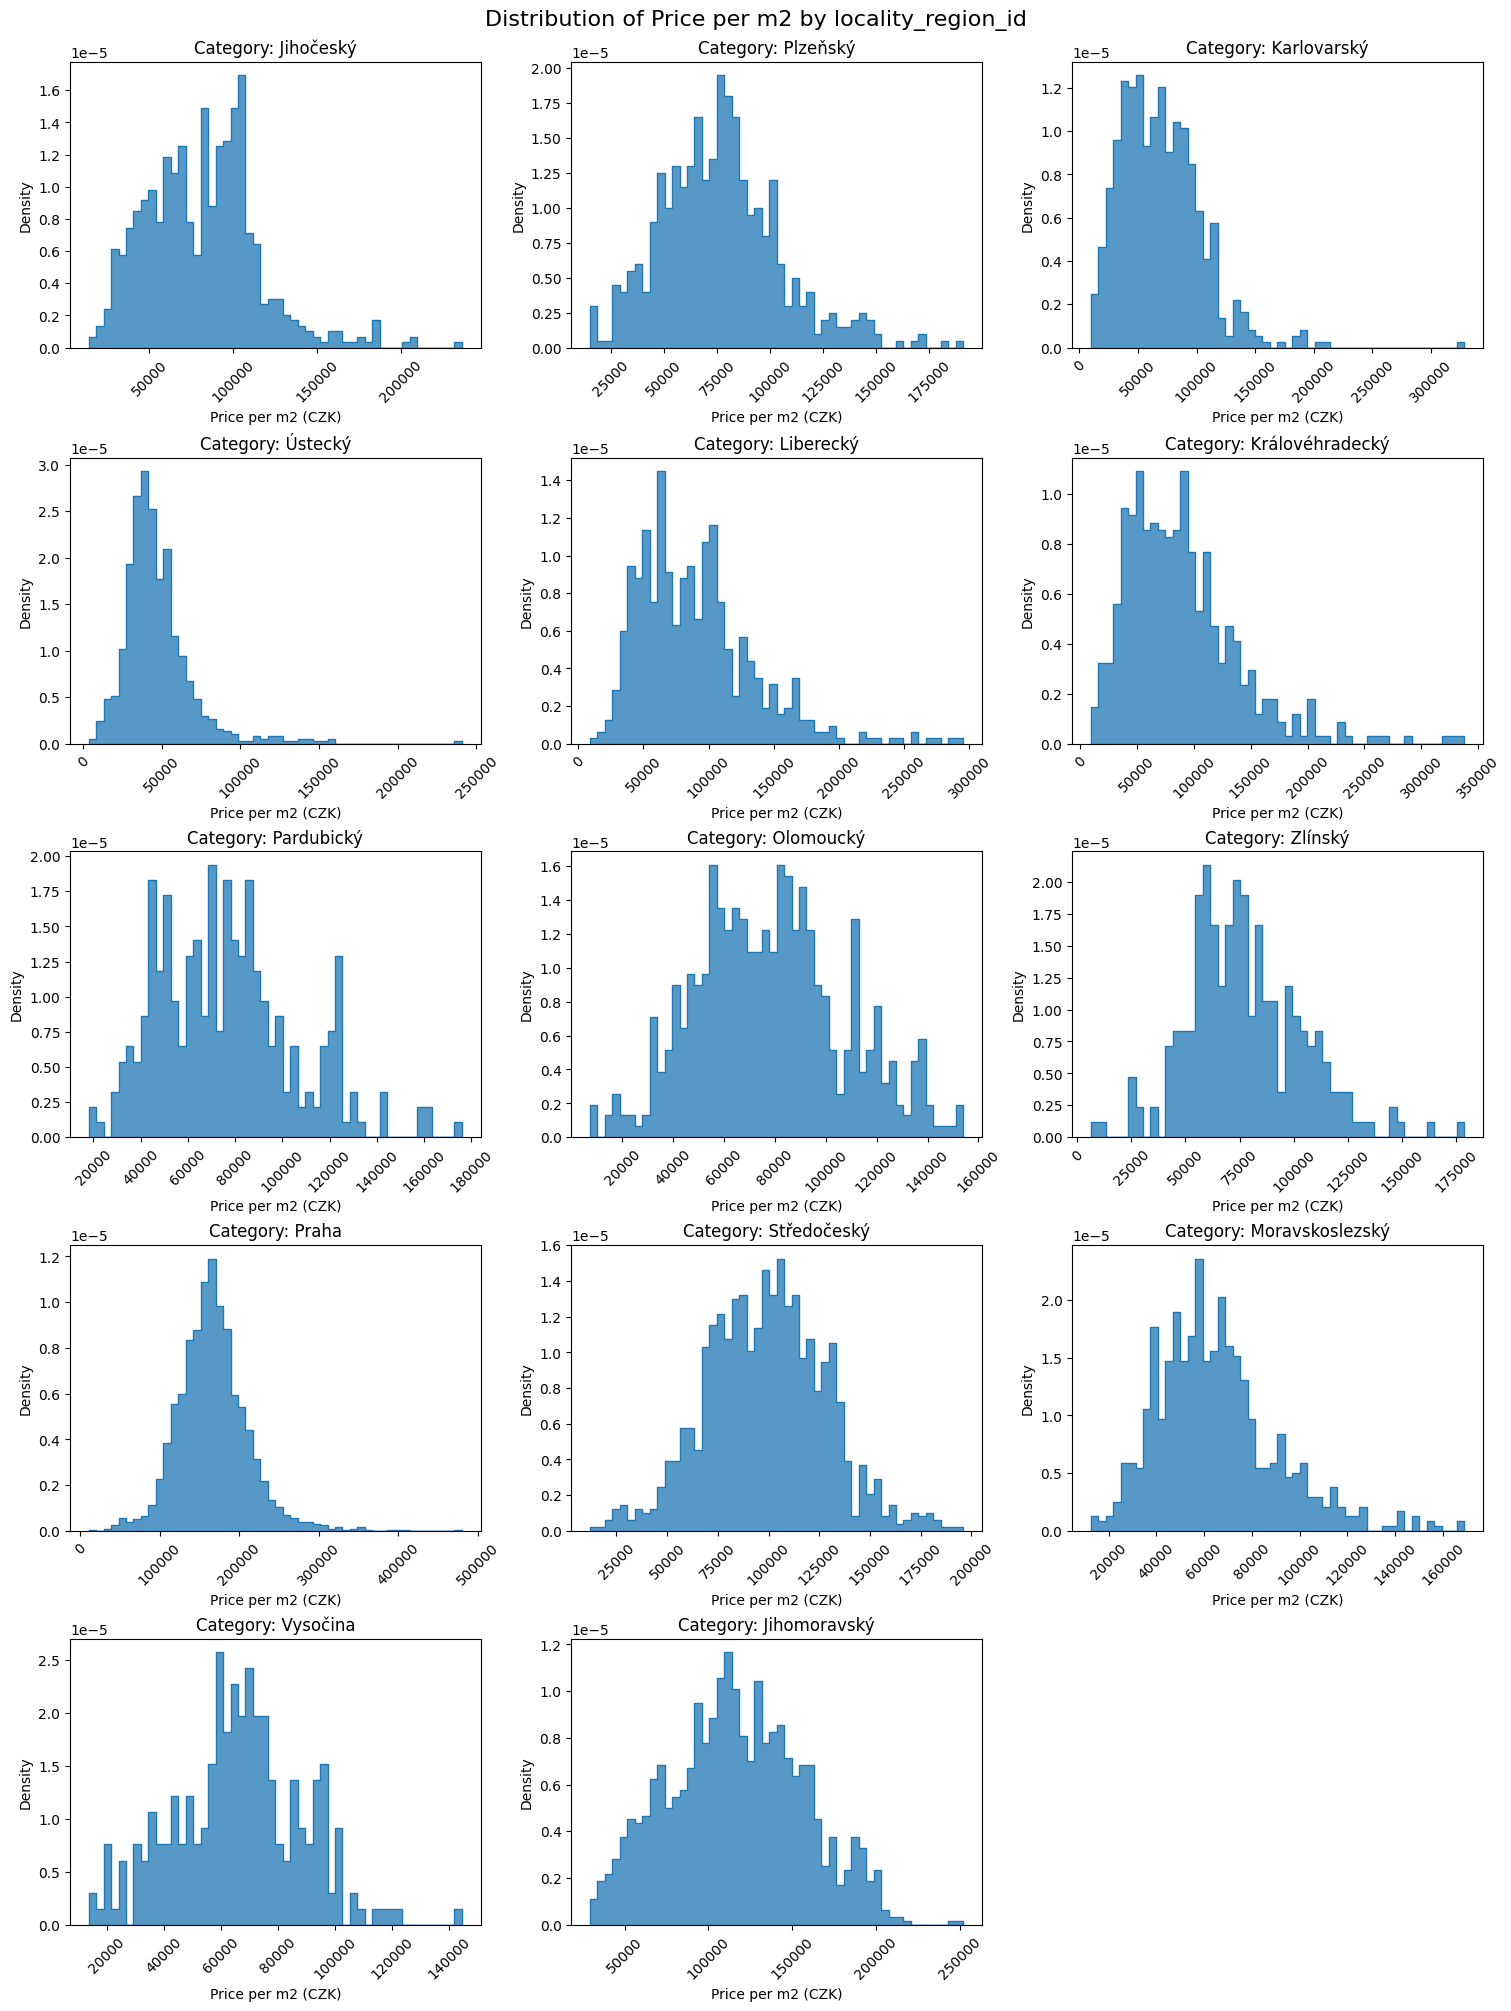

In [137]:
hist_price_based_on_category('locality_region_id',category_locality_Region_id)


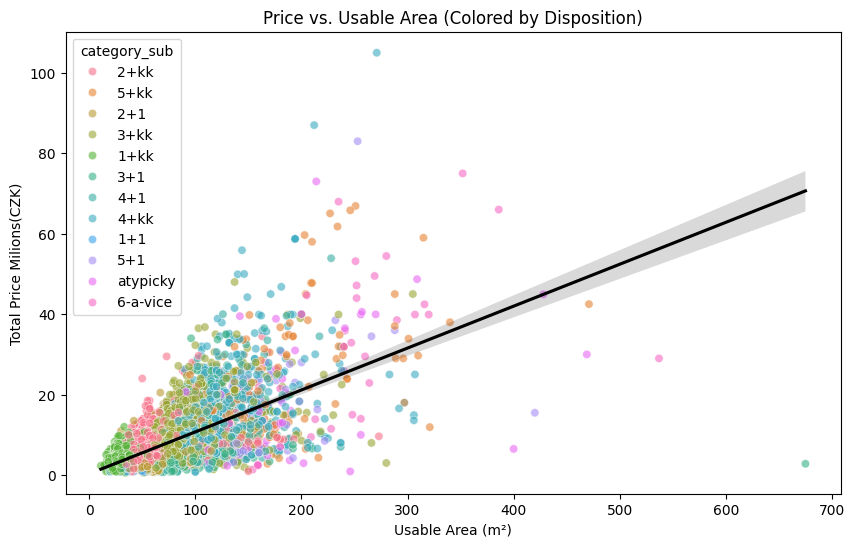

In [ ]:

plt.figure(figsize=(10, 6))
sns.scatterplot(data=df, x='usable_area_m2', y='price_millions', hue='category_sub', alpha=0.6)
sns.regplot(data=df, x='usable_area_m2', y='price_millions', scatter=False, color='black')
plt.title('Price vs. Usable Area (Colored by Disposition)')
plt.xlabel('Usable Area (m²)')
plt.ylabel('Total Price Milions(CZK)')
plt.show()


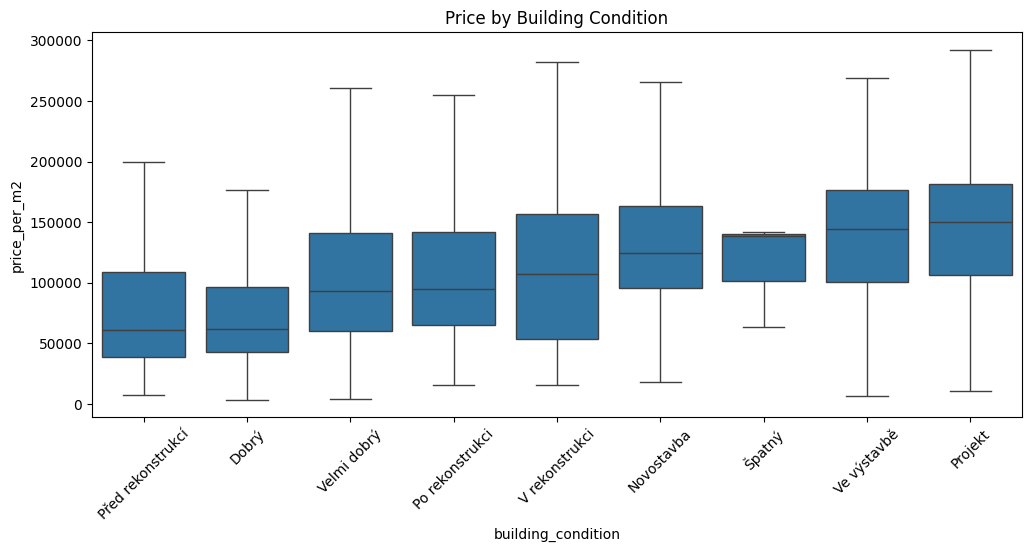

In [119]:
plt.figure(figsize=(12, 5))
sort_order = df.groupby('building_condition')['price_per_m2'].median().sort_values().index
sns.boxplot(data=df, x='building_condition', y='price_per_m2', order=sort_order, showfliers=False)
plt.xticks(rotation=45)
plt.title('Price by Building Condition')
plt.show()

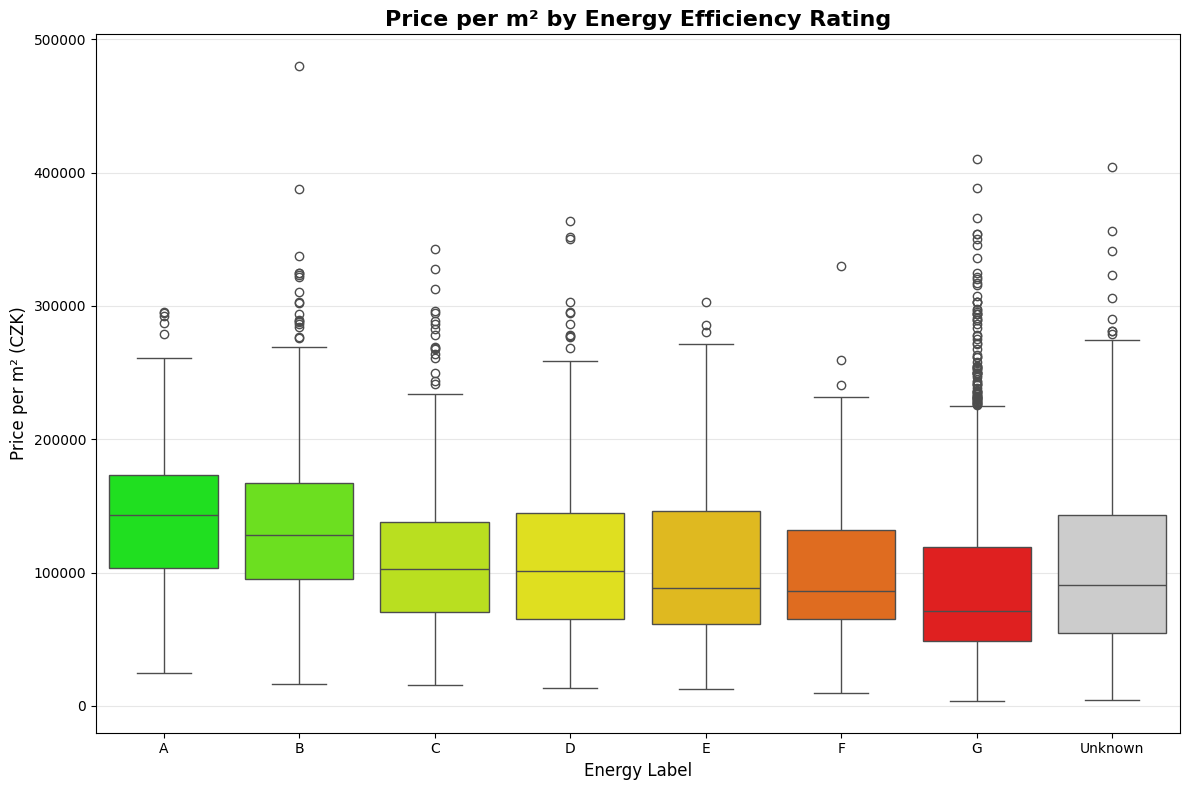

In [120]:
energy_gradient = {
    'A': '#00FF00',  # Bright Green
    'B': '#66FF00',  # Light Green
    'C': '#CCFF00',  # Yellow-Green
    'D': '#FFFF00',  # Yellow
    'E': '#FFCC00',  # Orange-Yellow
    'F': '#FF6600',  # Orange
    'G': '#FF0000',  # Red
    'Unknown': '#CCCCCC'  # Gray for unknown
}
df['energy_class'] = df['energy_class'].fillna('Unknown')
plt.figure(figsize=(12, 8))
sns.boxplot(data=df, x='energy_class', y='price_per_m2', 
            order=['A', 'B', 'C', 'D', 'E', 'F', 'G', 'Unknown'],
            hue='energy_class', 
            palette=energy_gradient,
            legend=False
            )
plt.title('Price per m² by Energy Efficiency Rating', fontsize=16, fontweight='bold')
plt.xlabel('Energy Label', fontsize=12)
plt.ylabel('Price per m² (CZK)', fontsize=12)
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
plt.grid(axis='y', alpha=0.3)
plt.tight_layout()
plt.show()

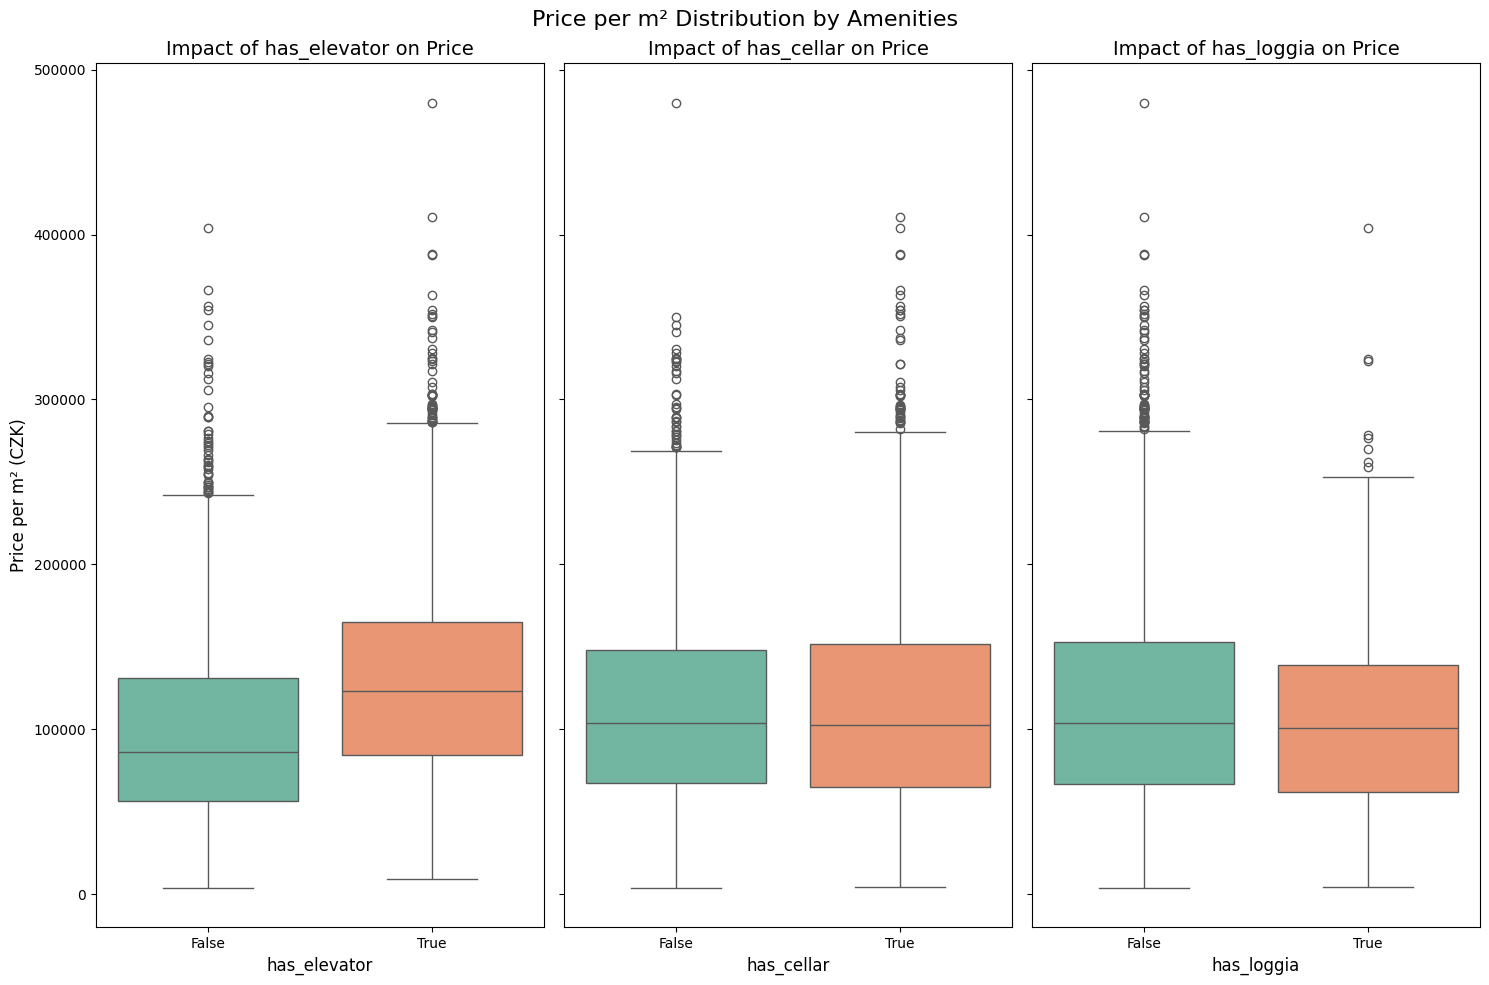

In [121]:
fig, axes = plt.subplots(1, 3, figsize=(15, 10), sharey=True)

amenities = ['has_elevator', 'has_cellar', 'has_loggia']

for i, col in enumerate(amenities):
    sns.boxplot(
        data=df, 
        x=col, 
        y='price_per_m2', 
        hue=col,            
        legend=False,       
        ax=axes[i], 
        palette='Set2'
    )
    
    # Formatting
    axes[i].set_title(f'Impact of {col} on Price', fontsize=14)
    axes[i].set_xlabel(col, fontsize=12)
    
    # Only show y-label for the first plot
    if i == 0:
        axes[i].set_ylabel('Price per m² (CZK)', fontsize=12)
    else:
        axes[i].set_ylabel('')

plt.suptitle('Price per m² Distribution by Amenities', fontsize=16)
plt.tight_layout()
plt.show()

In [122]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12534 entries, 0 to 12533
Data columns (total 38 columns):
 #   Column                    Non-Null Count  Dtype         
---  ------                    --------------  -----         
 0   id                        12534 non-null  int64         
 1   web_link                  12534 non-null  object        
 2   title                     12534 non-null  object        
 3   description               12534 non-null  object        
 4   category_sub              12534 non-null  object        
 5   price_total               12534 non-null  int64         
 6   currency                  12534 non-null  object        
 7   street                    12534 non-null  object        
 8   locality_region_id        12534 non-null  int64         
 9   district_id               12534 non-null  int64         
 10  municipality_id           12534 non-null  int64         
 11  latitude                  12534 non-null  float64       
 12  longitude         

In [123]:
df_clean=df.drop(columns=['id','description', 'web_link', 'title','currency','price_millions','price_per_m2',
                          'latitude', 'longitude', 'created_at', 'updated',
                          'municipality_id','locality_region_id'])

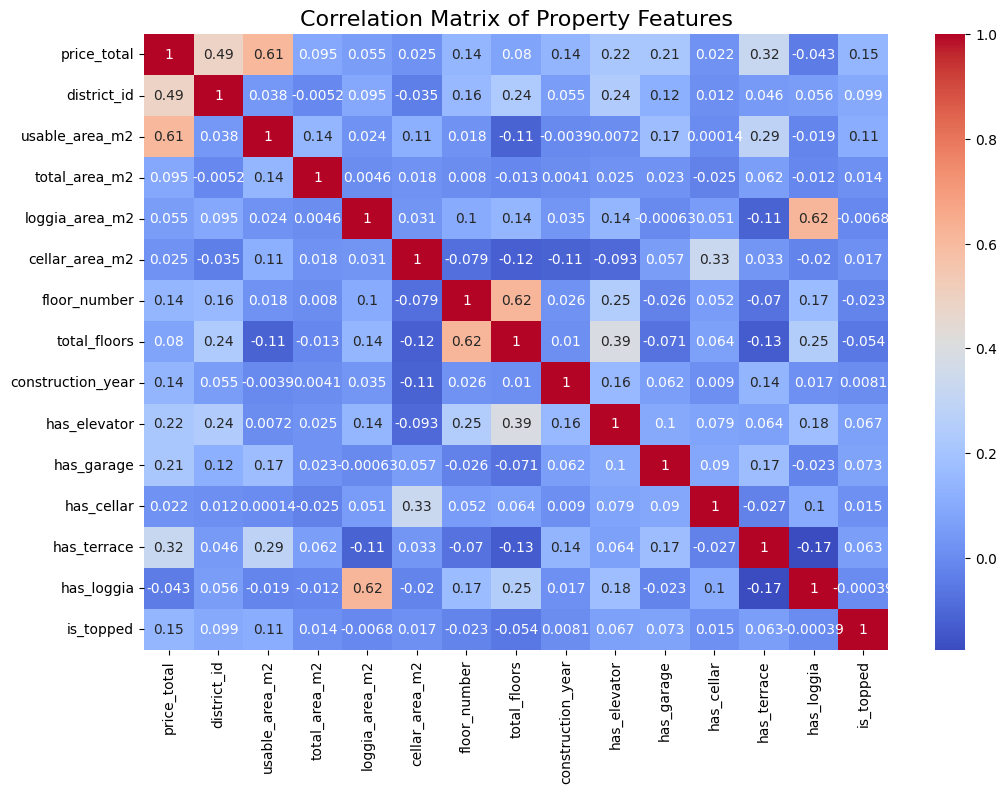

In [124]:
plt.figure(figsize=(12, 8))
sns.heatmap(df_clean.corr(numeric_only=True), annot=True, cmap='coolwarm')
plt.title('Correlation Matrix of Property Features', fontsize=16)
plt.show()